In [1]:
import numpy as np
import pandas as pd
import scipy.io
import scipy.optimize
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px

In [2]:
%config InlineBackend.figure_format = 'retina'
py.offline.init_notebook_mode(connected = True)

In [3]:
subj_list_GA = ['GA01', 'GA02', 'GA05', 'GA07', 'GA08', 
                'GA11', 'GA12', 'GA13', 'GA14', 'GA15', 
                'GA18', 'GA19', 'GA20', 'GA21', 'GA23', 
                'GA26', 'GA27', 'GA28', 'GA29', 'GA30', 
                'GA31', 'GA32', 'GA33', 'GA34', 'GA35',
                'GA36', 'GA37', 'GA38', 'GA42', 'GA44'] 

In [4]:
subj_list_GD = ['GD11', 'GD07', 'GD30', 'GD02', 'GD29',
                'GD32', 'GD23', 'GD01', 'GD31', 'GD33',
                'GD20', 'GD44', 'GD26']

In [5]:
subj_list = subj_list_GA
today = '20200821'
root_dir = '/Users/clmn/Desktop/GD'
behav_dir = root_dir + '/behav_data'
behav_AR_dir = '/Users/clmn/Desktop/GA/behavior_data/aspect_ratio/main_task'

In [6]:
sigma_1 = 0.682689492137
sigma_2 = 0.954499736104
sigma_3 = 0.997300203937

In [7]:
def exponential_fit(x, a, b, c):
    return a * (1 - np.exp(-b * x)) + c

In [8]:
def convert_ID(ID):
    x = np.int8(np.kron(np.ones(5),range(-2,3)))
    y = np.int8(np.kron(range(2,-3,-1),np.ones(5)))
    return (x[ID-1],y[ID-1])

In [9]:
def calc_mrew(behav_datum):
    # input : a subject's behavior datum (.mat file) while using fMRI. Bacuase of the sample rate 300
    # output : a block-by-block success rate (each RUN consists of 8 blocks)
    datum = scipy.io.loadmat(behav_datum)
    nS = 300   ## Number of sample(=frame) of 1 trial for run 2~7
    nR = 7
    W = 1   ## Size of a time bin
    nbin = W*60;   ## number of frame per a second. aka, the 'bin' means a frame.

    end = datum['LearnTrialStartTime'].shape[1]
    startTime = datum['LearnTrialStartTime'][0,range(0,end,97)]
    cnt_hit_all = np.zeros((datum['targetID'].shape[1],nS))

    for i,ID in enumerate(np.concatenate(datum['targetID'])):
        pos = datum['boxSize']*convert_ID(ID)
        xy = datum['allXY'][:,nS*i:nS*(i+1)]
        err = xy - np.int16(np.ones((2,300))*pos.T)
        cnt_hit_all[i,:] = (abs(err[0,:]) <= datum['boxSize']*0.5) & (abs(err[1,:]) <= datum['boxSize']*0.5)
    assert np.sum(np.sum(cnt_hit_all,axis=1)-datum['cnt_hit'])==0
    print('Matched...')

    rew_bin = np.zeros((nR,int(300*97/nbin)))
    for r in range(nR):
        tem = cnt_hit_all[97*r:97*(r+1),:].reshape(nS*97,1)
        for i in range(int(300*97/nbin)):
            rew_bin[r,i] = sum(tem[nbin*i:nbin*(i+1)])
            
    ntrial = 12
    nblock = 8
    nrun = 7
    max_score =  nS*ntrial   ## 60Hz*5s*12trials = frames
    temp = rew_bin[:,5:].reshape(nrun*5*ntrial*nblock)
    norm_mrew = np.zeros(nblock*nrun)
    for i in range(nblock*nrun):
        norm_mrew[i] = sum(temp[5*ntrial*i:5*ntrial*(i+1)])/max_score
    
    return norm_mrew

In [35]:
behav_datum = behav_dir + '/mrew_errR_30_run1to3_20190626.mat'
data = scipy.io.loadmat(behav_datum)
df = pd.DataFrame(columns = ['Early', 'Late', 'Long-After'])
da = pd.DataFrame(columns = ['Early', 'Late', 'Long-After'])

mrew_data = {}
for subj in subj_list_GA:
    index = subj[0]+subj[2:]
    mrew_data[subj] = np.concatenate(data['%s_mrew_all' %subj])
    df.loc[index,'Early'] = np.mean(mrew_data[subj][:24])
    da.loc[index,'Early'] = (mrew_data[subj][:24])
    df.loc[index,'Late'] = np.mean(mrew_data[subj][24*6:24*7])
    da.loc[index,'Late'] = (mrew_data[subj][24*6:24*7])
    
mrew_data = {}
for subj in subj_list_GD:
    index = subj[0]+subj[2:]
    behav_datum = behav_dir + '/%s-refmri.mat' %subj
    mrew_data[subj] = calc_mrew(behav_datum)[:24]
    df.loc[index,'Long-After'] = np.mean(mrew_data[subj][:24])
    da.loc[index,'Long-After'] = (mrew_data[subj][:24])

Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...


In [36]:
behav_datum = behav_dir + '/mrew_errR_30_run1to3_20190626.mat'
prac_data = scipy.io.loadmat(behav_datum)
prac_data.keys()

mrew = {}

for subj in subj_list_GA:
    mrew[subj, 'practice'] = prac_data['%s_mrew_all' % subj][0]

behav_datum = behav_dir + '/mrew_errR_30_run4to6_20190626.mat'
unprac_data = scipy.io.loadmat(behav_datum)
unprac_data.keys()

for i, subj in enumerate(subj_list_GA):
    mrew[subj, 'unpractice'] = unprac_data['mrew_run4to6'][i]

## Success Rate

In [37]:
dg = df[df['Long-After']>0]

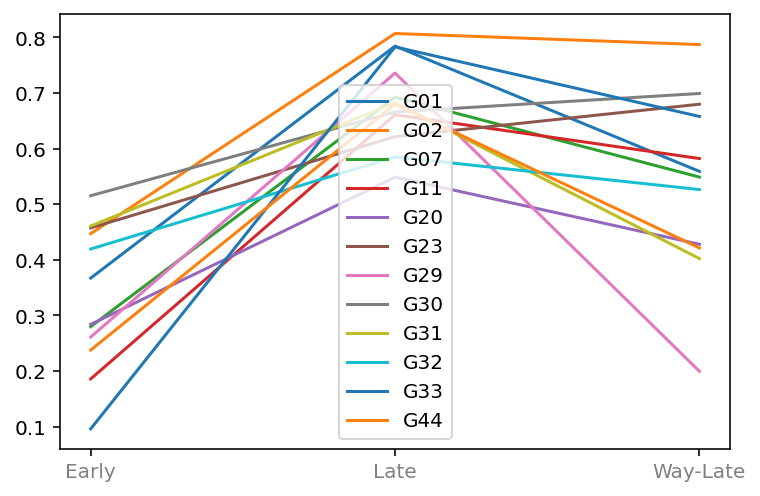

In [38]:
for e, l, wl in zip(dg['Early'], dg['Late'], dg['Long-After']):
    plt.plot((0, 1, 2), (e, l, wl))
    
plt.legend(dg.index)
plt.xticks(np.arange(3), labels=['Early','Late','Long-After'], fontsize='medium', color=(0.5, 0.5, 0.5))
#plt.grid()
plt.savefig(fname=today+'_behav1.png', dpi=300)
plt.show()

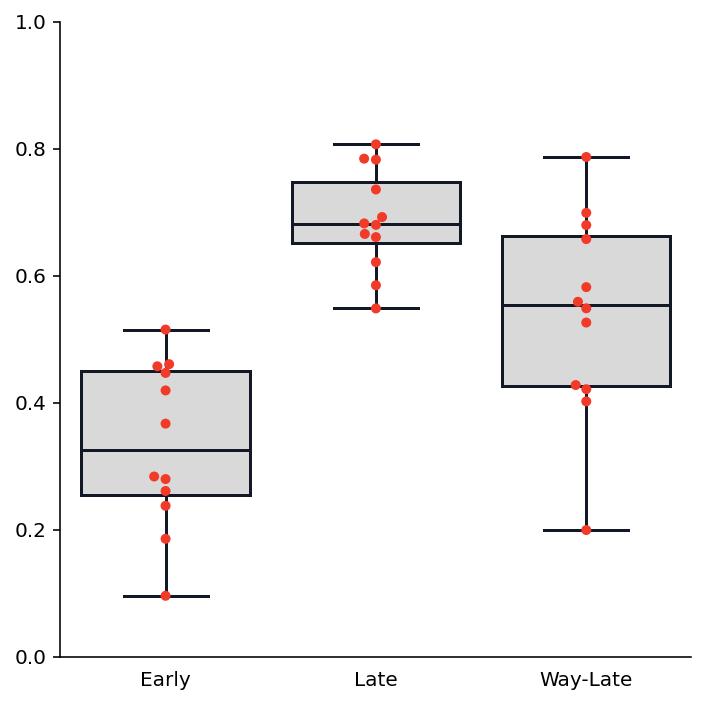

In [39]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.boxplot(data=dg, palette=["#D9D9D9"])
sns.swarmplot(data=dg, size=5, color="#F23A29", linewidth=0)

plt.ylim(0, 1.0)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

for i, artist in enumerate(ax.artists):
    artist.set_edgecolor("#131826")
    
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color("#131826")
        line.set_mfc("#131826")
        line.set_mec("#131826")
        
#for e, l in zip(early_rwd, late_rwd):
#    line = plt.plot((0, 1), (e, l), '-', linewidth=1)
#    line[0].set_color("#99999999")
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
)

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right=False,         # ticks along the top edge are off
)

plt.tight_layout()

fig.set_facecolor('white')

fig.savefig(fname=today+'_behav2.png', dpi=300)

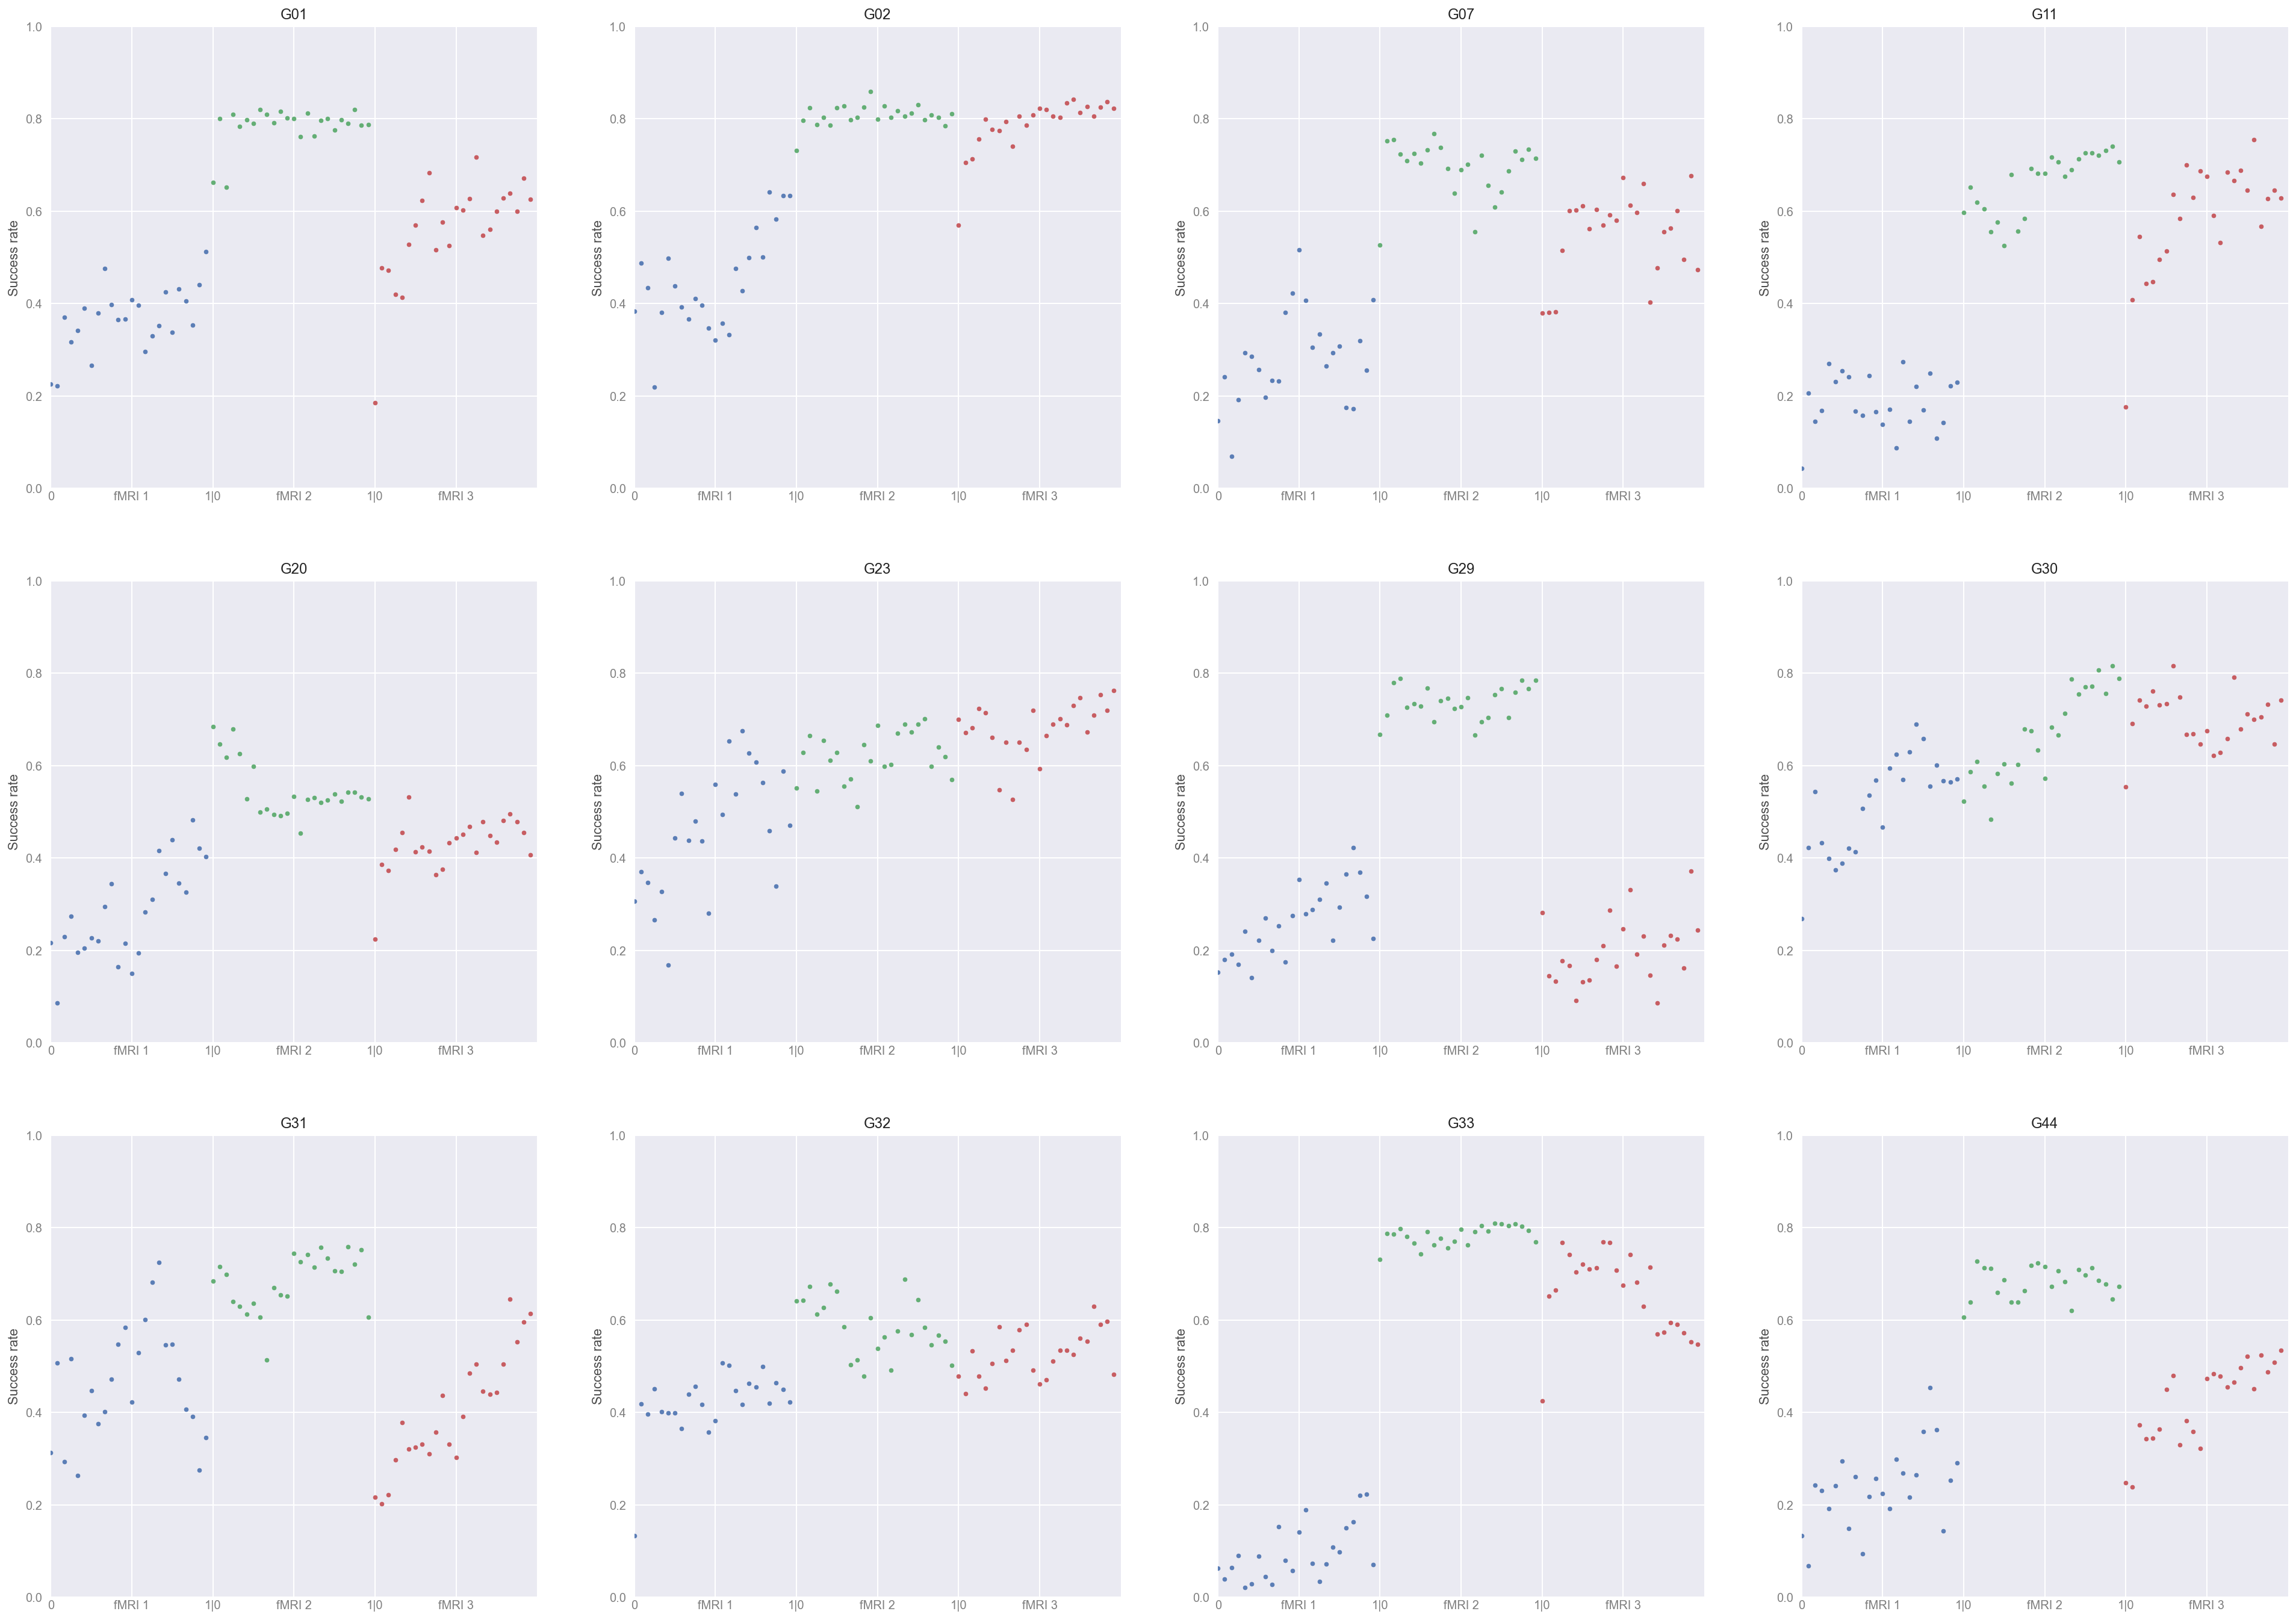

In [40]:
# figure for paper

fig, ax = plt.subplots()
fig.set_size_inches(33.3, 24)
fit_results = []

plt.style.use('seaborn')

for i, subj in enumerate(dg.index):
    plt.subplot(3, 4, i+1)
    plt.grid(True)
    
    x = np.arange(24)/24
    y = da.loc[subj,'Early']
    plt.scatter(x, y, marker='.', alpha=0.9)
#     popt, pcov = scipy.optimize.curve_fit(exponential_fit, x, y)
#     plt.plot(x, exponential_fit(x, *popt), 'k--')
#     plt.text(3.1, 0.345, 'A = %.2f' % (popt[0]), fontsize=10, color=(0.5, 0.5, 0.5))
#     plt.text(3.1, 0.2825, 'B = %.2f' % (popt[1]), fontsize=10, color=(0.5, 0.5, 0.5))
#     plt.text(3.1, 0.22, 'C = %.2f' % (popt[2]), fontsize=10, color=(0.5, 0.5, 0.5))
    x = np.array(range(24))/24 + 1
    y = da.loc[subj,'Late']
    plt.scatter(x, y, marker='.', alpha=0.9)
    x = np.array(range(24))/24 + 2
    y = da.loc[subj,'Long']
    plt.scatter(x, y, marker='.', alpha=0.9)
    
    #plt.title('Subject %d' % (i+1))
    plt.title(subj)
    plt.ylim(0, 1)
    plt.xlim(0, 3)
    plt.ylabel('Success rate', color=(0.3, 0.3, 0.3))
    
    if i > 26:
        plt.xlabel('Session', color=(0.3, 0.3, 0.3))
        
    plt.yticks(color=(0.5, 0.5, 0.5))
    plt.xticks(np.arange(6)*0.5,
               labels=[0,'fMRI 1', '1|0', 'fMRI 2', '1|0', 'fMRI 3'], ha='center', va='center',
               fontsize='medium', color=(0.5, 0.5, 0.5))
    #fit_results.append((popt, pcov))

plt.show()
fig.savefig(today+'_behav3.png', dpi=300)

In [41]:
da

,Early,Late,Way-Late
G01,"[0.22583333333333333, 0.2213888888888889, 0.37...","[0.6625, 0.8008333333333333, 0.651666666666666...","[0.185, 0.4777777777777778, 0.4716666666666667..."
G02,"[0.3827777777777778, 0.48722222222222217, 0.43...","[0.7319444444444445, 0.7963888888888888, 0.824...","[0.5702777777777778, 0.7052777777777778, 0.713..."
G05,"[0.04055555555555555, 0.40222222222222226, 0.2...","[0.5083333333333333, 0.6336111111111111, 0.722...",NaN
G07,"[0.14638888888888887, 0.24083333333333334, 0.0...","[0.5269444444444444, 0.7522222222222222, 0.755...","[0.3794444444444444, 0.3811111111111111, 0.382..."
G08,"[0.2638888888888889, 0.23305555555555557, 0.41...","[0.41944444444444445, 0.6463888888888889, 0.64...",NaN
G11,"[0.043611111111111114, 0.20638888888888887, 0....","[0.5975, 0.6525, 0.6188888888888888, 0.605, 0....","[0.1761111111111111, 0.4083333333333333, 0.544..."
G12,"[0.1322222222222222, 0.1525, 0.167222222222222...","[0.5627777777777778, 0.6947222222222222, 0.572...",NaN
G13,"[0.13583333333333333, 0.2544444444444444, 0.33...","[0.7358333333333333, 0.7269444444444445, 0.741...",NaN
G14,"[0.12194444444444445, 0.12805555555555556, 0.1...","[0.4716666666666667, 0.6027777777777779, 0.605...",NaN
G15,"[0.10833333333333334, 0.20527777777777778, 0.2...","[0.715, 0.6825, 0.7711111111111112, 0.74166666...",NaN


In [42]:
a = len(da.loc['G01','Early'])
b = len(da.loc['G01','Late'])
c = len(da.loc['G01','Long-After'])
print(a,b,c)

24 24 24


In [43]:
content_df = pd.DataFrame(columns=['subj', 'Mapping', 'Trial', 'Reward'])

#for j, subj in enumerate(subj_list_GA):
for j, subj in enumerate(subj_list_GA):
    for i in range(168):
        content_df = content_df.append({'subj': subj, 
                                        'Mapping': 'Trained', 
                                        'Trial': i, 
                                        'Reward': mrew[subj, 'practice'][i]}, 
                                       ignore_index=True)
        
    for i in range(24):
        content_df = content_df.append({'subj': subj, 
                                        'Mapping': 'Untrained', 
                                        'Trial': i, 
                                        'Reward': mrew[subj, 'unpractice'][i]}, 
                                       ignore_index=True)
        
    for i in range(24, 48):
        content_df = content_df.append({'subj': subj, 
                                        'Mapping': 'Untrained2', 
                                        'Trial': i + 120, 
                                        'Reward': mrew[subj, 'unpractice'][i]}, 
                                       ignore_index=True)

In [44]:
content_df[(content_df['subj']=='GA01')&(content_df['Mapping']=='Trained')]

,subj,Mapping,Trial,Reward
0,GA01,Trained,0,0.225833
1,GA01,Trained,1,0.221389
2,GA01,Trained,2,0.370833
3,GA01,Trained,3,0.316389
4,GA01,Trained,4,0.341389
...,...,...,...,...
163,GA01,Trained,163,0.798333
164,GA01,Trained,164,0.789444
165,GA01,Trained,165,0.820000
166,GA01,Trained,166,0.785833


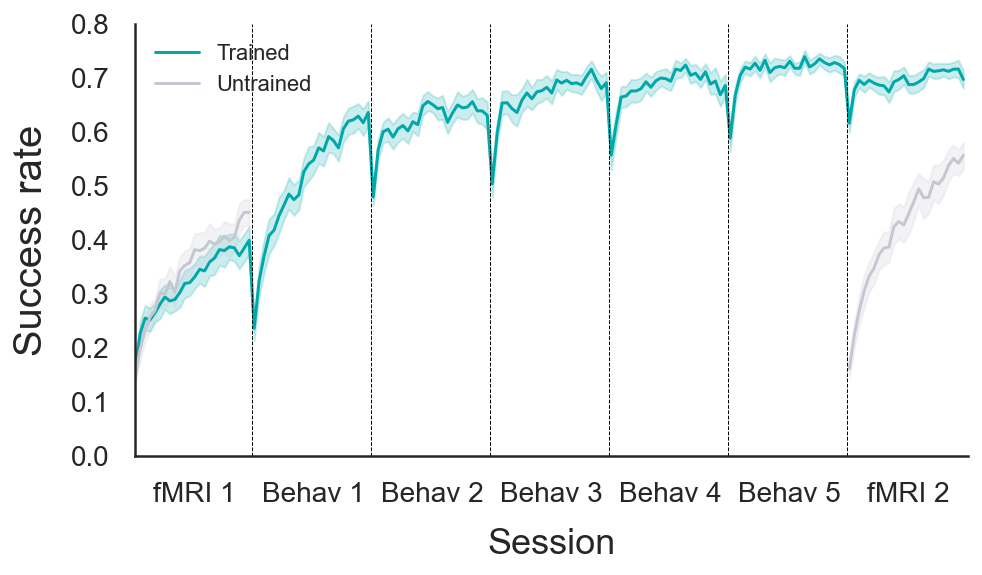

In [54]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 4.2)

collist = ['#00A8AA', '#C5C7D2']

plot_mrew = sns.lineplot(x='Trial', y='Reward', data=content_df[content_df['Mapping'] != 'Untrained2'], 
                         hue='Mapping', 
                         palette=collist, ci=68)

plot_mrew.set(xlim=(0, 168), ylim=(0, 0.8))
sns.despine(right=True)

for visit in list(range(23, 167, 24)):
    plot_mrew.axvline(x=visit+0.5, linewidth=0.5, linestyle='--', color="black")

#for visit in [23, 143]:
#    plot_mrew.axvline(x=visit+0.4, linewidth=1, color="black")

sns.lineplot(x='Trial', y='Reward', hue='Mapping', data=content_df[content_df['Mapping'] == 'Untrained2'], 
             palette=[collist[-1]], ci=68, legend=False)

sns.set(style="white")
plt.xlabel("Session", fontsize=18, labelpad=10)
plt.ylabel("Success rate", fontsize=20, labelpad=10)
plt.xticks(np.arange(12, 168, step=24), ['fMRI 1', 'Behav 1', 'Behav 2', 'Behav 3', 'Behav 4', 'Behav 5', 'fMRI 2'], fontsize=14, )
plt.yticks(fontsize=14)
#ax.get_xticklabels()[0].set_color('#AA162A')
#ax.get_xticklabels()[-1].set_color('#2060A5')

plt.setp(ax.get_legend().get_texts(), fontsize='14') # for legend teacuxt
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title
ax.xaxis.set_ticks_position('none') 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])

#ax.get_xticklabels()[0].set_weight('bold')
#ax.get_xticklabels()[-1].set_weight('bold')

plt.tight_layout()

fig.savefig(today+'_behav4.png', dpi=300)

## Paper figures

In [31]:
behav_datum = behav_dir + '/mrew_errR_30_run1to3_20190626.mat'
prac_data = scipy.io.loadmat(behav_datum)
prac_data.keys()

mrew = {}

for subj in subj_list_GA:
    mrew[subj, 'practice'] = prac_data['%s_mrew_all' % subj][0]

behav_datum = behav_dir + '/mrew_errR_30_run4to6_20190626.mat'
unprac_data = scipy.io.loadmat(behav_datum)
unprac_data.keys()

for i, subj in enumerate(subj_list_GA):
    mrew[subj, 'unpractice'] = unprac_data['mrew_run4to6'][i]
content_df = pd.DataFrame(columns=['subj', 'Mapping', 'Trial', 'Reward'])

#for j, subj in enumerate(subj_list_GA):
for j, subj in enumerate(subj_list_GD):
    behav_datum = behav_dir + '/%s-refmri.mat' %subj
    g_name = subj[0]+subj[2:]
    ga_name = g_name[0]+'A'+g_name[1:]
    temp = calc_mrew(behav_datum)
    #temp = np.zeros(56)
    for i in range(168):
        # fMRI 1_trained + behavior 1-5 + fMRI 2_trained
        content_df = content_df.append({'subj': g_name,
                                        'Mapping': 'Trained', 
                                        'Trial': i, 
                                        'Reward': mrew[ga_name, 'practice'][i]}, 
                                       ignore_index=True)
        
    for i in range(24):
        # fMRI 1_untrained
        content_df = content_df.append({'subj': g_name,
                                        'Mapping': 'Untrained',
                                        'Trial': i,
                                        'Reward': mrew[ga_name, 'unpractice'][i]}, 
                                       ignore_index=True)
        # fMRI 3_trained
        content_df = content_df.append({'subj': g_name,
                                        'Mapping': 'Trained2',
                                        'Trial': i + 168,
                                        'Reward': temp[i]}, 
                                       ignore_index=True)
        # fMRI 3_untrained
        content_df = content_df.append({'subj': g_name,
                                        'Mapping': 'Untrained3',
                                        'Trial': i + 168,
                                        'Reward': temp[i+24]}, 
                                       ignore_index=True)
        
    for i in range(24, 48):
        # fMRI 2_untrained
        content_df = content_df.append({'subj': g_name,
                                        'Mapping': 'Untrained2',
                                        'Trial': i + 120,
                                        'Reward': mrew[ga_name, 'unpractice'][i]}, 
                                       ignore_index=True)

Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...


In [32]:
content_df

,subj,Mapping,Trial,Reward
0,G11,Trained,0,0.043611
1,G11,Trained,1,0.206389
2,G11,Trained,2,0.144722
3,G11,Trained,3,0.168611
4,G11,Trained,4,0.270000
...,...,...,...,...
3427,G26,Untrained2,163,0.601389
3428,G26,Untrained2,164,0.704167
3429,G26,Untrained2,165,0.741944
3430,G26,Untrained2,166,0.714722


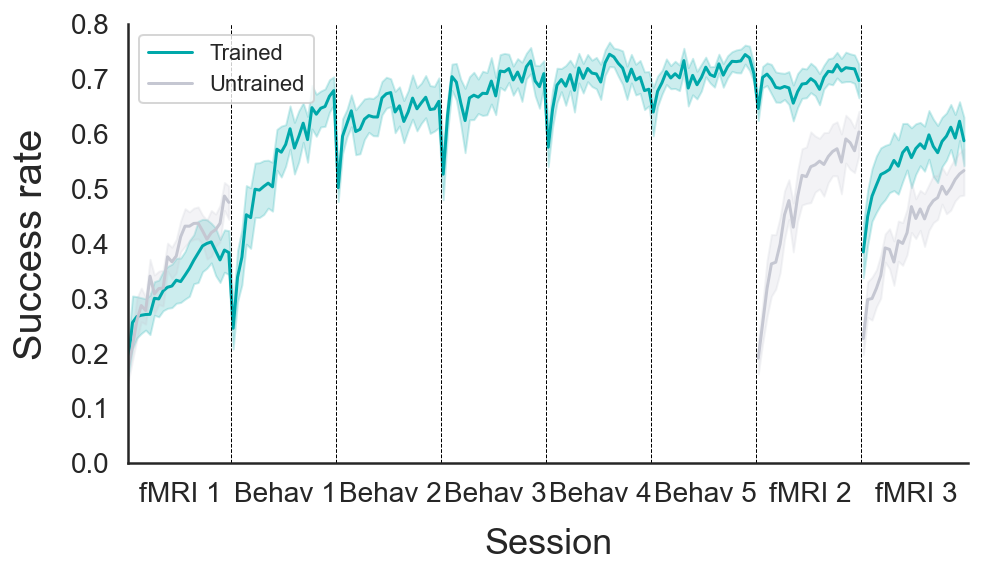

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 4.2)

collist = ['#00A8AA', '#C5C7D2', '#C5C7D2']

plot_mrew = sns.lineplot(x='Trial', y='Reward', hue='Mapping', palette=collist[:2], ci=sigma_1*100,
                         data=content_df[(content_df['Mapping']=='Trained')|(content_df['Mapping']=='Untrained')])
sns.lineplot(x='Trial', y='Reward', hue='Mapping', palette=collist, ci=sigma_1*100, legend=False,
             data=content_df[(content_df['Mapping']=='Trained2')|(content_df['Mapping']=='Untrained2')|(content_df['Mapping']=='Untrained3')])

plot_mrew.set(xlim=(0, 192), ylim=(0, 0.8))
sns.despine(right=True)

for visit in list(range(23, 191, 24)):
    plot_mrew.axvline(x=visit+0.5, linewidth=0.5, linestyle='--', color="black")

sns.set(style="white")
plt.xlabel("Session", fontsize=18, labelpad=10)
plt.ylabel("Success rate", fontsize=20, labelpad=10)
plt.xticks(np.arange(12, 192, step=24), ['fMRI 1', 'Behav 1', 'Behav 2', 'Behav 3', 'Behav 4', 'Behav 5', 'fMRI 2', 'fMRI 3'], fontsize=14, )
plt.yticks(fontsize=14)

plt.setp(ax.get_legend().get_texts(), fontsize='14') # for legend teacuxt
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title
ax.xaxis.set_ticks_position('none') 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])

plt.tight_layout()

fig.savefig(today+'_behav5.png', dpi=300)

## Trajectory

In [34]:
def get_allXY_components(i):
    switcher = {
        'r01':range(0,97*300),
        'r02':range(97*300,97*300*2),
        'r03':range(97*300*2,97*300*3),
        'r04':range(97*300*3,97*300*4),
        'r05':range(97*300*4,97*300*5),
        'r06':range(97*300*5,97*300*6),
        'r07':range(97*300*6,97*300*7),
    }
    return switcher.get(i,"Invalid RUN")

In [35]:
def trajectory(behav_datum, allXY_pad=87300, sample_sec=0.0167, cursor_traj=False):
    # load dataset
    behav_data = scipy.io.loadmat(behav_datum)
    
    # preprocessing
    allXY = behav_data['allXY'][:, :allXY_pad]
    
    return allXY

In [36]:
subj_list = subj_list_GD

result = {}

for subj in subj_list:
    allXY = trajectory(behav_datum=behav_dir+'/%s-refmri.mat'%subj, allXY_pad=87300*2)

    result[subj, 'long-after'] = (
        allXY[:, get_allXY_components('r01')],
        allXY[:, get_allXY_components('r02')],
        allXY[:, get_allXY_components('r03')],
    )

In [37]:
def draw_trajectory(subj, stage, run):
    xs = []
    ys = []
    cs = []
    rr = run-1
    
    allXY = result[subj, stage][rr]

    for i in range(0, allXY.shape[1], 2):
        x = allXY[0, i]
        y = allXY[1, i]

        xs.append(-x)
        ys.append(-y)
    
    fig, ax = plt.subplots(figsize=(5, 5))
        
    for s in range(0, len(xs), 30):
        #plt.scatter(xs, ys, c='k', alpha=0.5)
        plt.plot(xs[s:s+31], ys[s:s+31], 'k-', alpha=0.3)
        #plt.plot(xs, ys, 'k.', alpha=0.5)

    plt.xlim(420, -420)
    plt.ylim(420, -420)
    plt.title('%s, r%02d'%(subj,run))
    
    plt.show()
    
    return fig

In [38]:
result['GD31', 'long-after'][0].shape

(2, 29100)

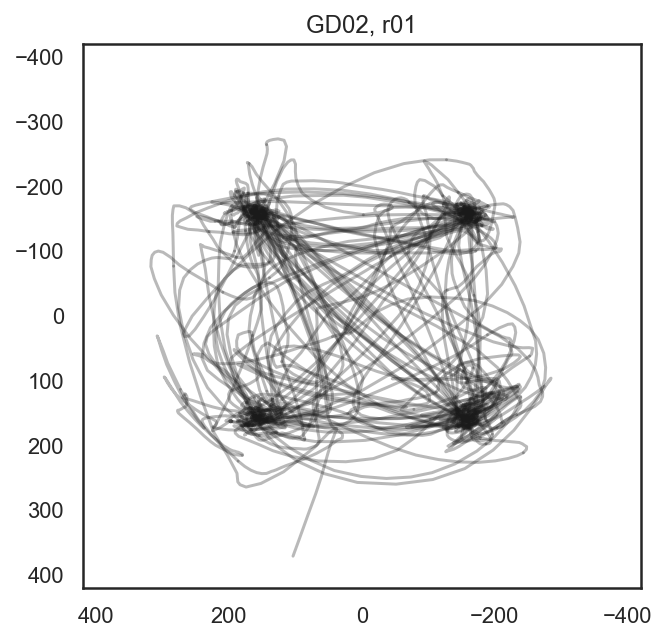

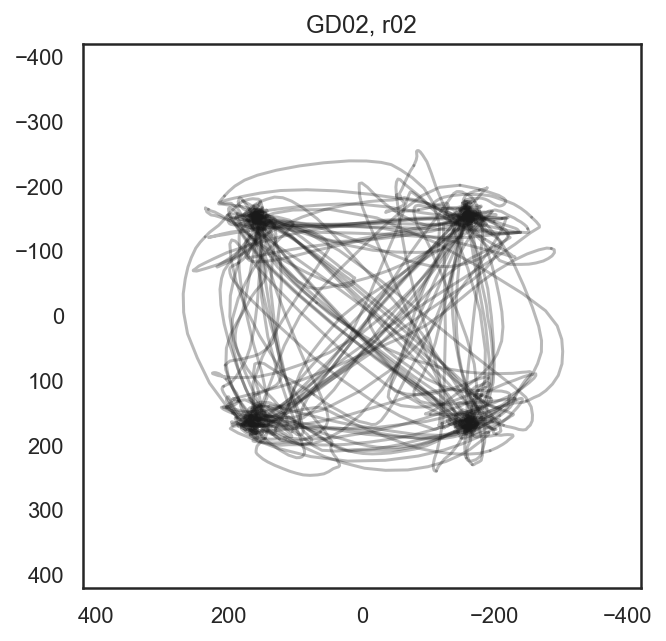

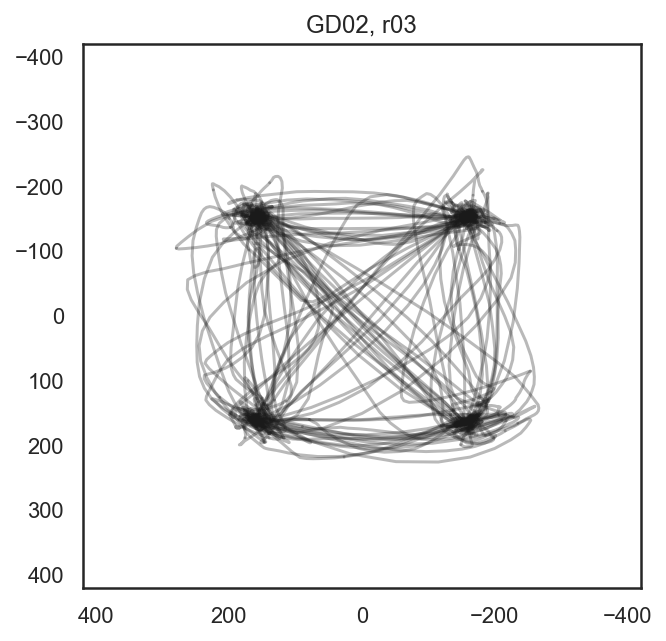

In [39]:
for i in range(3):
    draw_trajectory('GD02', 'long-after', i+1)
#fig.savefig(today+'_trajectory_GA27_early.png', dpi=300)

## Aspect Ratio

In [40]:
df = pd.read_csv(behav_AR_dir + '/AL_maintask_all_averaged_new-idx.tsv', sep='\s+')
df = df[df['mapping']=='Practiced']
df['block'] = np.kron(np.ones(30),np.array(range(168)))
df_mean = df.groupby('block').mean()
df_SE = df.groupby('block').sem()
df

,subj,visit,run,block,mapping,AR,idx,path,new_idx
0,GA01,1,1,0.0,Practiced,0.684241,5.5,6.5,5.5
1,GA01,1,1,1.0,Practiced,0.840756,17.5,6.5,17.5
2,GA01,1,1,2.0,Practiced,0.772533,29.5,6.5,29.5
3,GA01,1,1,3.0,Practiced,0.530420,41.5,6.5,41.5
4,GA01,1,1,4.0,Practiced,0.433959,53.5,6.5,53.5
...,...,...,...,...,...,...,...,...,...
6451,GA44,7,3,163.0,Practiced,0.164340,233.5,6.5,1955.5
6452,GA44,7,3,164.0,Practiced,0.143200,245.5,6.5,1967.5
6453,GA44,7,3,165.0,Practiced,0.185619,257.5,6.5,1979.5
6454,GA44,7,3,166.0,Practiced,0.196721,269.5,6.5,1991.5


In [42]:
px.line(df_mean,y=df_mean['AR'],error_y=df_SE['AR'])

In [43]:
temp = pd.read_csv(behav_AR_dir + '/AL_maintask_all_averaged_new-idx.tsv', sep='\s+')
temp['Mapping'] = [a.replace('practic', 'train').replace('Practic', 'Train') for a in temp['mapping']]

In [44]:
temp

,subj,visit,run,block,mapping,AR,idx,path,new_idx,Mapping
0,GA01,1,1,1,Practiced,0.684241,5.5,6.5,5.5,Trained
1,GA01,1,1,2,Practiced,0.840756,17.5,6.5,17.5,Trained
2,GA01,1,1,3,Practiced,0.772533,29.5,6.5,29.5,Trained
3,GA01,1,1,4,Practiced,0.530420,41.5,6.5,41.5,Trained
4,GA01,1,1,5,Practiced,0.433959,53.5,6.5,53.5,Trained
...,...,...,...,...,...,...,...,...,...,...
6475,GA44,7,6,164,Unpracticed,0.412334,233.5,6.5,1955.5,Untrained
6476,GA44,7,6,165,Unpracticed,0.512902,245.5,6.5,1967.5,Untrained
6477,GA44,7,6,166,Unpracticed,0.556753,257.5,6.5,1979.5,Untrained
6478,GA44,7,6,167,Unpracticed,0.918876,269.5,6.5,1991.5,Untrained


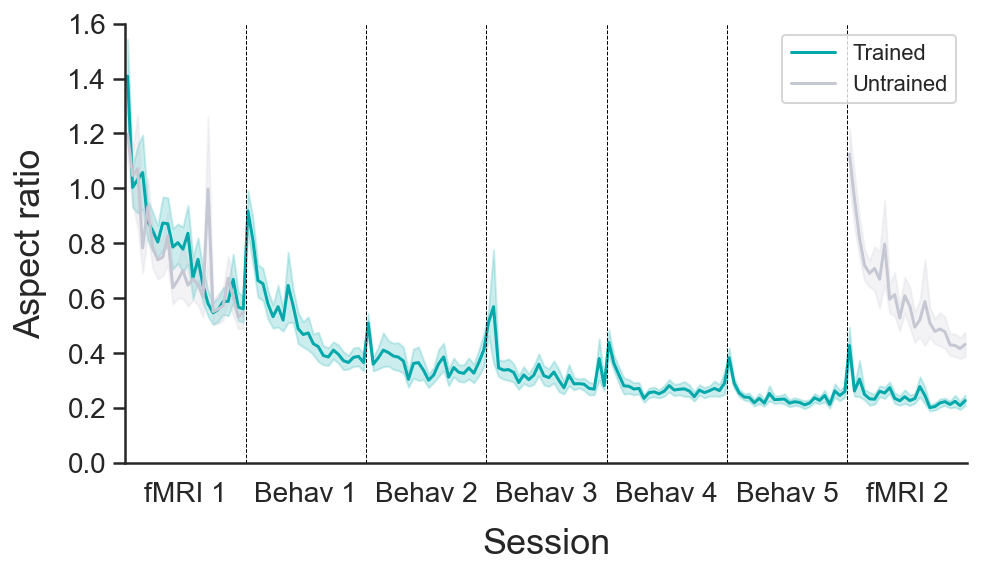

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 4.2)

collist = ['#00A8AA', '#C5C7D2']

plot_mrew = sns.lineplot(x='new_idx', y='AR', data=temp[(temp['mapping'] != 'Unpracticed') | (temp['visit']!=7)], hue='Mapping',
                         palette=['#00A8AA', '#C5C7D2'], ci=68)

plot_mrew.set(xlim=(0, 2009), ylim=(0, 1.6))
sns.despine(right=True)

for visit in list(range(287, 2009, 287)):
    plot_mrew.axvline(x=visit+0.5, linewidth=0.5, linestyle='--', color="black")

#for visit in [23, 143]:
#    plot_mrew.axvline(x=visit+0.4, linewidth=1, color="black")
    
sns.lineplot(x='new_idx', y='AR', hue='Mapping', data=temp[(temp['mapping'] == 'Unpracticed') & (temp['visit']==7)], 
             palette=['#C5C7D2'], ci=68, legend=False)
    
sns.set(style="white")
plt.xlabel("Session", fontsize=18, labelpad=10)
plt.ylabel("Aspect ratio", fontsize=18, labelpad=10)
plt.xticks(np.arange(287/2, 2009, 287), ['fMRI 1', 'Behav 1', 'Behav 2', 'Behav 3', 'Behav 4', 'Behav 5', 'fMRI 2'], fontsize=14, )
plt.yticks(fontsize=14)
#ax.get_xticklabels()[0].set_color('#AA162A')
#ax.get_xticklabels()[-1].set_color('#2060A5')

plt.setp(ax.get_legend().get_texts(), fontsize='14') # for legend teacuxt
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('none') 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])

#ax.get_xticklabels()[0].set_weight('bold')
#ax.get_xticklabels()[-1].set_weight('bold')

plt.tight_layout()

fig.savefig('20200422_aspect_ratio.png', dpi=300)